1) Import all needed packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
%matplotlib inline

2) Create a function return histogram of gradients (HOG) features

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    """ Returns histogram of gradients features from input image"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

2a) Show examples of vehicles and non-vehicles

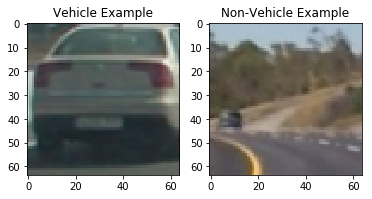

In [3]:
exampleVehicle = r'./output_images/exampleVehicle.png'
vehicleImg = mpimg.imread(exampleVehicle)
exampleNonVehicle = r'./output_images/exampleNonVehicle.png'
nonVehicleImg = mpimg.imread(exampleNonVehicle)

fig = plt.figure()
plt.subplot(121)
plt.imshow(vehicleImg)
plt.title('Vehicle Example')
plt.subplot(122)
plt.imshow(nonVehicleImg)
plt.title('Non-Vehicle Example')
plt.savefig(r'./output_images/trainingExamples.png')

2b) Show examples of HOG features for vehicles and non-vehicles

C:\Users\chauv\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


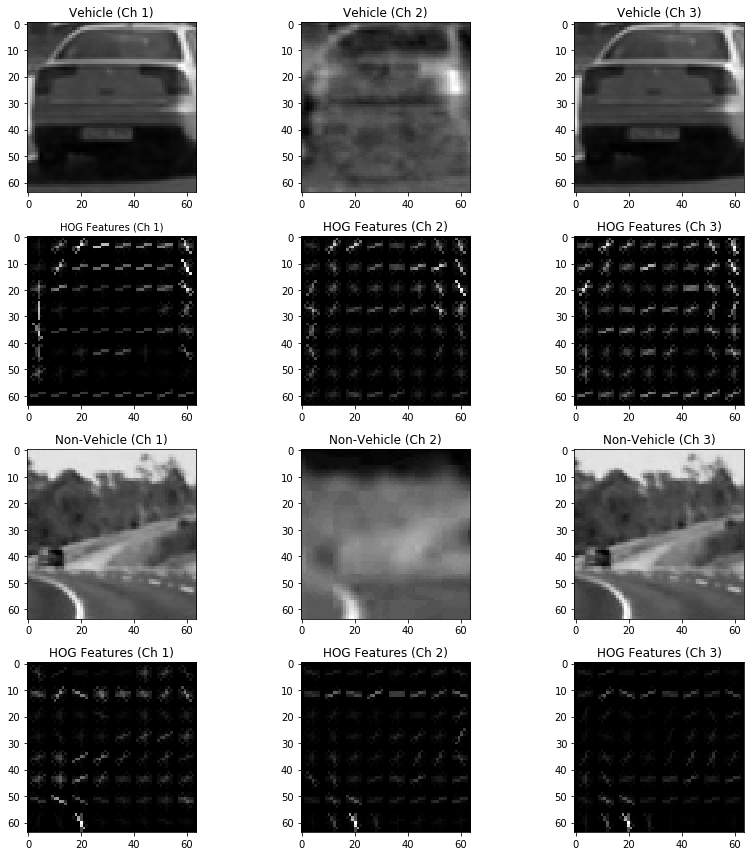

In [4]:
exampleVehicle = r'./output_images/exampleVehicle.png'
vimg = mpimg.imread(exampleVehicle)
vimgYCrCb = cv2.cvtColor(vimg, cv2.COLOR_RGB2YCrCb)
features, vhog_image1 = get_hog_features(vimgYCrCb[:,:,0], 9, 8, 2, vis=True)
features, vhog_image2 = get_hog_features(vimgYCrCb[:,:,1], 9, 8, 2, vis=True)
features, vhog_image3 = get_hog_features(vimgYCrCb[:,:,2], 9, 8, 2, vis=True)

exampleNonVehicle = r'./output_images/exampleNonVehicle.png'
nimg = mpimg.imread(exampleNonVehicle)
nimgYCrCb = cv2.cvtColor(nimg, cv2.COLOR_RGB2YCrCb)
features, nhog_image1 = get_hog_features(nimgYCrCb[:,:,0], 9, 8, 2, vis=True)
features, nhog_image2 = get_hog_features(nimgYCrCb[:,:,1], 9, 8, 2, vis=True)
features, nhog_image3 = get_hog_features(nimgYCrCb[:,:,2], 9, 8, 2, vis=True)

fig = plt.figure(figsize=(12,12))
plt.subplot(431)
plt.imshow(vimgYCrCb[:,:,0], cmap='gray')
plt.title('Vehicle (Ch 1)')
plt.subplot(434)
plt.imshow(vhog_image1, cmap='gray')
plt.title('HOG Features (Ch 1)', fontsize=10)
plt.subplot(432)
plt.imshow(vimgYCrCb[:,:,1], cmap='gray')
plt.title('Vehicle (Ch 2)')
plt.subplot(435)
plt.imshow(vhog_image2, cmap='gray')
plt.title('HOG Features (Ch 2)')
plt.subplot(433)
plt.imshow(vimgYCrCb[:,:,0], cmap='gray')
plt.title('Vehicle (Ch 3)')
plt.subplot(436)
plt.imshow(vhog_image3, cmap='gray')
plt.title('HOG Features (Ch 3)')
plt.subplot(437)
plt.imshow(nimgYCrCb[:,:,0], cmap='gray')
plt.title('Non-Vehicle (Ch 1)')
plt.subplot(4,3,10)
plt.imshow(nhog_image1, cmap='gray')
plt.title('HOG Features (Ch 1)')
plt.subplot(438)
plt.imshow(nimgYCrCb[:,:,1], cmap='gray')
plt.title('Non-Vehicle (Ch 2)')
plt.subplot(4,3,11)
plt.imshow(nhog_image2, cmap='gray')
plt.title('HOG Features (Ch 2)')
plt.subplot(4,3,9)
plt.imshow(nimgYCrCb[:,:,0], cmap='gray')
plt.title('Non-Vehicle (Ch 3)')
plt.subplot(4,3,12)
plt.imshow(nhog_image3, cmap='gray')
plt.title('HOG Features (Ch 3)')
fig.tight_layout()
plt.savefig(r'./output_images/exampleHOG.png')

3) Create a function to return spatial features

In [5]:
def bin_spatial(img, size=(32, 32)):
    """ Returns raw pixel values from each color channel for a window
    of a certain size
    """
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

4) Create a function to return color channel histogram features

In [6]:
def color_hist(img, nbins=32):
    """ Returns color channel histogram features """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

5) Create a function to return sliding windows for feature extraction

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """ Generates list of sliding windows for analysis """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1.0 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1.0 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*xy_overlap[0])
    ny_buffer = np.int(xy_window[1]*xy_overlap[1])
    nx_windows = np.int((x_span - nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((y_span - ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate each window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

6) Create a function to extract the HOG, spatial, and histogram features from a defined portion of the input image

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """ Extracts HOG, spatial, and histogram features within an image """
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

7) Create a function to locate cars within an image using the extracted features and a pre-trained classifier

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, color_space,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    """ Generates a list of bounding boxes around objects within the input image
    that have been identified as cars """
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)  
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialize list of bounding boxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))       
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

8) Create a function to add a unit of heat to each pixel covered by each bounding box

In [10]:
def add_heat(heatmap, bbox_list):
    """ Adds a unit of heat to each pixel that lies within a list of bounding boxes """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

9) Create a function to remove heat from each pixel whose heat value falls below the defined threshold

In [11]:
def apply_threshold(heatmap, threshold):
    """ Removes heat from pixels whose values lies below a defined threshold """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

10) Create a function to draw the bounding boxes in the input image

In [12]:
def draw_labeled_bboxes(img, labels, returnBbox=False):
    """ Draws labeled bounding boxes in an input image """
    # Iterate through all detected cars
    bboxList = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxList.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and the bounding boxes if desired
    if returnBbox:
        return img, bboxList
    else:
        # Return the image
        return img

# Main Program

11) Create training and test sets for cars and notcars:

In [13]:
# Get paths to vehicle and non-vehicle training images
# Note: cars images have been manually separated into train/test sets
cars_train = glob.glob(r'./vehicles/*/train/*.png')
cars_test = glob.glob(r'./vehicles/*/test/*.png')
cars = cars_train + cars_test
notcars = glob.glob(r'./non-vehicles/*/*.png')

# Randomly assign notcars to train and test arrays
inds = np.random.permutation(range(len(notcars)))
inds_train = inds[:np.int(0.8*len(notcars))]
inds_test = inds[np.int(0.8*len(notcars)):]
notcars_train = [notcars[i] for i in inds_train]
notcars_test = [notcars[i] for i in inds_test]
notcars = notcars_train + notcars_test

print('Number of cars examples: %d' % len(cars))
print('Number of cars in train group: %d, test group: %d' % (len(cars_train), len(cars_test)))
print('Number of notcars examples: %d' % len(notcars))
print('Number of notcars in train group: %d, test group: %d' % (len(notcars_train), len(notcars_test)))

Number of cars examples: 8792
Number of cars in train group: 7024, test group: 1768
Number of notcars examples: 8968
Number of notcars in train group: 7174, test group: 1794


12) Extract the features in the training images, scale the feature values, label the resulting data as "car" and "notcar," then train the classifier. Save the scaler and the trained classifier to output for later use.

In [14]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split scaled_X back into cars and notcars arrays
car_features_scaled = scaled_X[:len(car_features), :]
notcar_features_scaled = scaled_X[len(car_features):, :]

# Separate features sets into train and test sets
X_train = np.vstack((car_features_scaled[:len(cars_train), :], 
                     notcar_features_scaled[:len(notcars_train), :]))
X_test = np.vstack((car_features_scaled[len(cars_train):, :], 
                    notcar_features_scaled[len(notcars_train):, :]))

# Define the labels vector for the train and test sets
#y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
y_train = np.hstack((np.ones(len(cars_train)), np.zeros(len(notcars_train))))
y_test = np.hstack((np.ones(len(cars_test)), np.zeros(len(notcars_test))))

# Randomize the order of the elements in the training and test sets
trainInds = np.random.permutation(range(len(X_train)))
X_train = np.array([X_train[i] for i in trainInds])
y_train = np.array([y_train[i] for i in trainInds])
testInds = np.random.permutation(range(len(X_test)))
X_test = np.array([X_test[i] for i in testInds])
y_test = np.array([y_test[i] for i in testInds])

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save the classifier and scaler
joblib.dump(svc, 'svc.sav')
joblib.dump(X_scaler, 'X_scaler.sav') 

C:\Users\chauv\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


19.96 Seconds to train SVC...
Test Accuracy of SVC =  0.9927
My SVC predicts:  [ 1.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  0.  1.  1.  1.  1.]
0.0015 Seconds to predict 10 labels with SVC


['X_scaler.sav']

13) Read in the scaler and trained classifier and test them on a test image

C:\Users\chauv\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


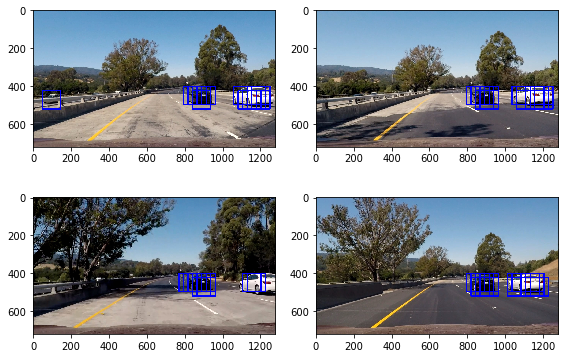

In [15]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

# Restore classifier and scaler
svc = joblib.load('svc.sav')
X_scaler = joblib.load('X_scaler.sav')

# Find the cars in a test image
ystart = 400
ystop = 656
scale = 1.5

testImgs = glob.glob(r'./test*.jpg')
drawImgs = []
for imgPath in testImgs:
    img = mpimg.imread(imgPath)
    draw_img = np.copy(img)
    
    bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, color_space, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins)
    for box in bbox_list:
        cv2.rectangle(draw_img, box[0], box[1],(0,0,255),6)
        
    drawImgs.append(draw_img)

fig = plt.figure(figsize=(8,8))
for i in range(len(drawImgs)):
    plt.subplot(3,2,i+1)
    plt.imshow(drawImgs[i])
    fig.tight_layout()
plt.savefig(r'./output_images/classifier.png')

14) Apply heat map to the test image to remove false positives:

C:\Users\chauv\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


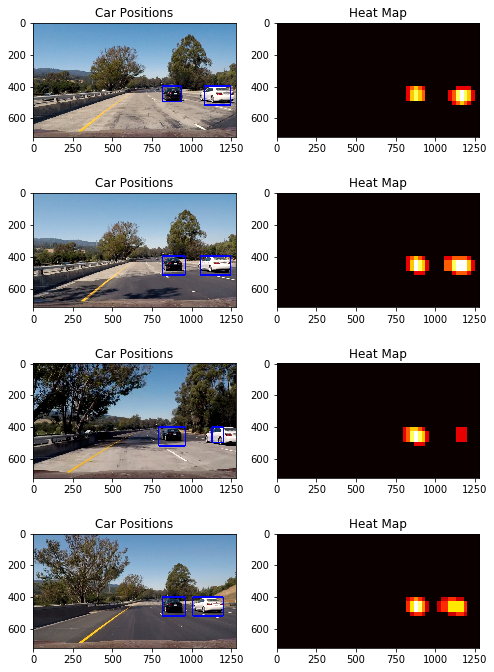

In [16]:
testImgs = glob.glob(r'./test*.jpg')
drawImgs = []
heatmaps = []
# Add heat to each box in box list
for imgPath in testImgs:
    image = mpimg.imread(imgPath)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, color_space, pix_per_cell, 
                          cell_per_block, spatial_size, hist_bins)
    heat = add_heat(heat, bbox_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    heatmaps.append(heatmap)
    
    # Label the heatmaps to form a single bounding box for each car
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    drawImgs.append(draw_img)

plt.figure(figsize=(8,12))
for i in range(len(drawImgs)):
    plt.subplot(4,2,2*i+1)
    plt.imshow(drawImgs[i])
    plt.title('Car Positions')
    plt.subplot(4,2,2*i+2)
    plt.imshow(heatmaps[i], cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

plt.savefig(r'./output_images/heatmap.png')

15) Create a HeatHistory class to enable integration and smoothing of heat values over time

In [17]:
class HeatHistory:
    def __init__(self, maxHeat=5):
        self.heat = np.zeros([720, 1280])
        self.maxHeat = maxHeat
        
    def clipHeat(self):
        self.heat[self.heat > self.maxHeat] = self.maxHeat
        
    def addHeat(self, heat):
        self.heat += heat
        self.clipHeat()
        
    def getHeat(self):
        return self.heat
    
    def removeHeat(self):
        self.heat[self.heat > 1] -= 1
        

16) Form algorithm pipeline:

In [18]:
def pipeline(image, heatHistory, threshold=3):
    frameBboxList = []
    # Define scales and start/stop values for y
    scales = [1.5, 1.0]
    ystarts = [400, 400]
    ystops = [656, 656]
    # Loop over scales to find bounding boxes
    for i, scale in enumerate(scales):
        bbox_list = find_cars(image, ystarts[i], ystops[i], scale, svc, X_scaler, orient, color_space, 
                              pix_per_cell, cell_per_block, spatial_size, hist_bins)
        frameBboxList.extend(bbox_list)
    # Use heatmaps for false alarm rejection
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, frameBboxList)
    heatHistory.addHeat(heat)
    heat = apply_threshold(heatHistory.getHeat(), threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img, labeledBboxList = draw_labeled_bboxes(np.copy(image), labels, returnBbox=True)
    # Remove one element of heat from the history
    heatHistory.removeHeat()
    return draw_img

16a) Create pipeline examples

C:\Users\chauv\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


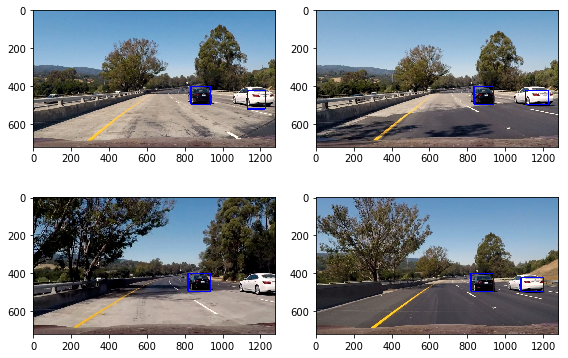

In [19]:
testImgs = glob.glob(r'./test*.jpg')
drawImgs = []
for imgPath in testImgs:
    img = mpimg.imread(imgPath)
    heatHistory = HeatHistory()
    draw_img = pipeline(img, heatHistory, threshold=3)
    drawImgs.append(draw_img)
    
fig = plt.figure(figsize=(8,8))
for i in range(len(drawImgs)):
    plt.subplot(3,2,i+1)
    plt.imshow(drawImgs[i])
    fig.tight_layout()
plt.savefig(r'./output_images/pipelineExamples.png')

17) Process the video:

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

class Video_Processing():
    def __init__(self):
        self.heatHistory = HeatHistory()
        
    def processFrame(self, image):
        return pipeline(image, self.heatHistory, threshold=3)
    
vp = Video_Processing()
videoOutput = 'project_video_result.mp4'
video = VideoFileClip('project_video.mp4') #.subclip(0,15)
videoClip = video.fl_image(vp.processFrame)
%time videoClip.write_videofile(videoOutput, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [24:04<00:01,  1.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 24min 4s
